In [65]:
import os
import random
import torch
import numpy as np
import soundfile as sf
from torch.utils import data
from torchaudio_augmentations import (
    RandomResizedCrop,
    RandomApply,
    PolarityInversion,
    Noise,
    Gain,
    HighLowPass,
    Delay,
    PitchShift,
    Reverb,
    Compose,
)


GTZAN_GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


class GTZANDataset(data.Dataset):
    def __init__(self, data_path, split, num_samples, num_chunks, is_augmentation):
        self.data_path =  data_path if data_path else ''
        self.split = split
        self.num_samples = num_samples
        self.num_chunks = num_chunks
        self.is_augmentation = is_augmentation
        self.genres = GTZAN_GENRES
        self._get_song_list()
        if is_augmentation:
            self._get_augmentations()

    def _get_song_list(self):
        list_filename = os.path.join(self.data_path, '%s_filtered.txt' % self.split)
        with open(list_filename) as f:
            lines = f.readlines()
        self.song_list = [line.strip() for line in lines]

    def _get_augmentations(self):
        transforms = [
            RandomResizedCrop(n_samples=self.num_samples),
            RandomApply([PolarityInversion()], p=0.8),
            RandomApply([Noise(min_snr=0.3, max_snr=0.5)], p=0.3),
            RandomApply([Gain()], p=0.2),
            RandomApply([HighLowPass(sample_rate=22050)], p=0.8),
            RandomApply([Delay(sample_rate=22050)], p=0.5),
            RandomApply([PitchShift(n_samples=self.num_samples, sample_rate=22050)], p=0.4),
            RandomApply([Reverb(sample_rate=22050)], p=0.3),
        ]
        self.augmentation = Compose(transforms=transforms)

    def _adjust_audio_length(self, wav):
        if self.split == 'train':
            random_index = random.randint(0, len(wav) - self.num_samples - 1)
            wav = wav[random_index : random_index + self.num_samples]
        else:
            hop = (len(wav) - self.num_samples) // self.num_chunks
            wav = np.array([wav[i * hop : i * hop + self.num_samples] for i in range(self.num_chunks)])
        return wav

    def __getitem__(self, index):
        line = self.song_list[index]

        # get genre
        genre_name = line.split('/')[0]
        genre_index = self.genres.index(genre_name)

        # get audio
        audio_filename = os.path.join(self.data_path, 'genres', line)
        wav, fs = sf.read(audio_filename)

        # adjust audio length
        wav = self._adjust_audio_length(wav).astype('float32')

        # data augmentation
        if self.is_augmentation:
            wav = self.augmentation(torch.from_numpy(wav).unsqueeze(0)).squeeze(0).numpy()

        return wav, genre_index

    def __len__(self):
        return len(self.song_list)

def get_dataloader(data_path=None, 
                   split='train', 
                   num_samples=22050 * 29, 
                   num_chunks=1, 
                   batch_size=16, 
                   num_workers=16, 
                   is_augmentation=False):
    is_shuffle = True if (split == 'train') else False
    batch_size = batch_size if (split == 'train') else (batch_size // num_chunks)
    data_loader = data.DataLoader(dataset=GTZANDataset(data_path, 
                                                       split, 
                                                       num_samples, 
                                                       num_chunks, 
                                                       is_augmentation),
                                  batch_size=batch_size,
                                  shuffle=is_shuffle,
                                  drop_last=False,
                                  num_workers=num_workers)
    return data_loader

curr_batchsize=16

In [91]:
train_loader = get_dataloader(split='train', is_augmentation=True)
iter_train_loader = iter(train_loader)
train_wav, train_genre = next(iter_train_loader)

valid_loader = get_dataloader(split='valid')
test_loader = get_dataloader(split='test')
iter_test_loader = iter(test_loader)
test_wav, test_genre = next(iter_test_loader)
print('training data shape: %s' % str(train_wav.shape))
print('validation/test data shape: %s' % str(test_wav.shape))
print(train_genre)


training data shape: torch.Size([16, 639450])
validation/test data shape: torch.Size([16, 1, 639450])
tensor([3, 7, 4, 9, 5, 1, 1, 4, 7, 6, 9, 6, 9, 5, 9, 6])


In [4]:
LearningRate=[1.0,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005]
for i in range(10):
    print(LearningRate[i])
    print(i)

1.0
0
0.5
1
0.1
2
0.05
3
0.01
4
0.005
5
0.001
6
0.0005
7
0.0001
8
5e-05
9


In [18]:
from torch import nn


class Conv_2d(nn.Module):
    def __init__(self, input_channels, output_channels, shape=3, pooling=2, dropout=0.1):
        super(Conv_2d, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, shape, padding=shape//2)
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(pooling)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, wav):
        out = self.conv(wav)
        out = self.bn(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.dropout(out)
        return out

In [22]:
import torchaudio


class CNN(nn.Module):
    def __init__(self, num_channels=16, 
                       sample_rate=22050, 
                       n_fft=1024, 
                       f_min=0.0, 
                       f_max=11025.0, 
                       num_mels=128, 
                       num_classes=10):
        super(CNN, self).__init__()

        # mel spectrogram
        self.melspec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, 
                                                            n_fft=n_fft, 
                                                            f_min=f_min, 
                                                            f_max=f_max, 
                                                            n_mels=num_mels)
        self.amplitude_to_db = torchaudio.transforms.AmplitudeToDB()
        self.input_bn = nn.BatchNorm2d(1)

        # convolutional layers
        self.layer1 = Conv_2d(1, num_channels, pooling=(2, 3))
        self.layer2 = Conv_2d(num_channels, num_channels, pooling=(3, 4))
        self.layer3 = Conv_2d(num_channels, num_channels * 2, pooling=(2, 5))
        self.layer4 = Conv_2d(num_channels * 2, num_channels * 2, pooling=(3, 3))
        self.layer5 = Conv_2d(num_channels * 2, num_channels * 4, pooling=(3, 4))

        # dense layers
        self.dense1 = nn.Linear(num_channels * 4, num_channels * 4)
        self.dense_bn = nn.BatchNorm1d(num_channels * 4)
        self.dense2 = nn.Linear(num_channels * 4, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, wav):
        # input Preprocessing
        out = self.melspec(wav)
        out = self.amplitude_to_db(out)

        # input batch normalization
        out = out.unsqueeze(1)
        out = self.input_bn(out)

        # convolutional layers
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        
        # reshape. (batch_size, num_channels, 1, 1) -> (batch_size, num_channels)
        out = out.reshape(len(out), -1)

        # dense layers
        out = self.dense1(out)
        out = self.dense_bn(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.dense2(out)

        return out


In [12]:


#if torch.backends.mps.is_available():
#    device = torch.device('mps')
#else:
#    print ("MPS device not found.")
device = torch.device('cpu')
LearningRate=[1.0,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005]
num_epochs = 30
Accuracies_lr=torch.FloatTensor(len(LearningRate), num_epochs) 
Loss_lr=torch.FloatTensor(len(LearningRate), num_epochs)
valid_losses = []

for i in range(5):
    print(LearningRate[i])
    cnn = CNN().to(device)
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(cnn.parameters(), lr=LearningRate[i])

    for epoch in range(num_epochs):
        losses = []

        # Train
        cnn.train()
        for (wav, genre_index) in train_loader:
            wav = wav.to(device)
            genre_index = genre_index.to(device)

            # Forward
            out = cnn(wav)
            loss = loss_function(out, genre_index)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print('Epoch: [%d/%d], Train loss: %.4f' % (epoch+1, num_epochs, np.mean(losses)))

        # Validation
        cnn.eval()
        y_true = []
        y_pred = []
        losses = []
        for wav, genre_index in valid_loader:
            wav = wav.to(device)
            genre_index = genre_index.to(device)

            # reshape and aggregate chunk-level predictions
            b, c, t = wav.size()
            logits = cnn(wav.view(-1, t))
            logits = logits.view(b, c, -1).mean(dim=1)
            loss = loss_function(logits, genre_index)
            losses.append(loss.item())
            _, pred = torch.max(logits.data, 1)

            # append labels and predictions
            y_true.extend(genre_index.tolist())
            y_pred.extend(pred.tolist())
        accuracy = accuracy_score(y_true, y_pred)
        Accuracies_lr[i][epoch]=accuracy
        valid_loss = np.mean(losses)
        Loss_lr[i][epoch]=valid_loss
        print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f' % (epoch+1, num_epochs, valid_loss, accuracy))
        print('Epoch: [%d/%d], Loss_lr[%d,%d]: %.4f Accuracies_lr[%d,%d]: %.4f' % (epoch+1, num_epochs, i, epoch, Loss_lr[i,epoch].item(), i, epoch, Accuracies_lr[i,epoch].item()))
        # Save model
        valid_losses.append(valid_loss.item())
        hyperparams = {'learning_rate': LearningRate[i], 'epoch': epoch, 'batch_size': curr_batchsize}
        if np.argmin(valid_losses) == i*num_epochs+epoch:
            print('Saving the best model at %d epochs!' % epoch)
            torch.save(cnn.state_dict(), '%d_best_model.ckpt' %curr_batchsize)
            torch.save(hyperparams, '%d_best_model_hyperparams.pt' %curr_batchsize)
            torch.save(test_loader, '%d_test_loader.pt' %curr_batchsize)

torch.save(Accuracies_lr,'%d_Accuracies_results.pt' %curr_batchsize)
torch.save(Loss_lr,'%d_Losses_results.pt' %curr_batchsize)
torch.save(dataloader_obj, 'dataloader.pth')

1.0
Epoch: [1/30], Train loss: 2.7222
Epoch: [1/30], Valid loss: 2.2602, Valid accuracy: 0.1980
Epoch: [1/30], Loss_lr[0,0]: 2.2602 Accuracies_lr[0,0]: 0.1980
Saving the best model at 0 epochs!
Epoch: [2/30], Train loss: 2.3464
Epoch: [2/30], Valid loss: 2.2160, Valid accuracy: 0.1218
Epoch: [2/30], Loss_lr[0,1]: 2.2160 Accuracies_lr[0,1]: 0.1218
Saving the best model at 1 epochs!
Epoch: [3/30], Train loss: 2.2785
Epoch: [3/30], Valid loss: 2.1629, Valid accuracy: 0.1929
Epoch: [3/30], Loss_lr[0,2]: 2.1629 Accuracies_lr[0,2]: 0.1929
Saving the best model at 2 epochs!
Epoch: [4/30], Train loss: 2.2737
Epoch: [4/30], Valid loss: 2.6452, Valid accuracy: 0.1015
Epoch: [4/30], Loss_lr[0,3]: 2.6452 Accuracies_lr[0,3]: 0.1015
Epoch: [5/30], Train loss: 2.2535
Epoch: [5/30], Valid loss: 2.2326, Valid accuracy: 0.1015
Epoch: [5/30], Loss_lr[0,4]: 2.2326 Accuracies_lr[0,4]: 0.1015
Epoch: [6/30], Train loss: 2.2713
Epoch: [6/30], Valid loss: 2.3179, Valid accuracy: 0.1066
Epoch: [6/30], Loss_lr[0

Epoch: [21/30], Train loss: 1.9557
Epoch: [21/30], Valid loss: 1.7156, Valid accuracy: 0.3604
Epoch: [21/30], Loss_lr[1,20]: 1.7156 Accuracies_lr[1,20]: 0.3604
Saving the best model at 20 epochs!
Epoch: [22/30], Train loss: 1.9688
Epoch: [22/30], Valid loss: 2.0144, Valid accuracy: 0.2487
Epoch: [22/30], Loss_lr[1,21]: 2.0144 Accuracies_lr[1,21]: 0.2487
Epoch: [23/30], Train loss: 1.9615
Epoch: [23/30], Valid loss: 2.9821, Valid accuracy: 0.1218
Epoch: [23/30], Loss_lr[1,22]: 2.9821 Accuracies_lr[1,22]: 0.1218
Epoch: [24/30], Train loss: 1.9109
Epoch: [24/30], Valid loss: 2.3214, Valid accuracy: 0.2030
Epoch: [24/30], Loss_lr[1,23]: 2.3214 Accuracies_lr[1,23]: 0.2030
Epoch: [25/30], Train loss: 1.8543
Epoch: [25/30], Valid loss: 2.5302, Valid accuracy: 0.1523
Epoch: [25/30], Loss_lr[1,24]: 2.5302 Accuracies_lr[1,24]: 0.1523
Epoch: [26/30], Train loss: 1.8833
Epoch: [26/30], Valid loss: 4.3945, Valid accuracy: 0.1218
Epoch: [26/30], Loss_lr[1,25]: 4.3945 Accuracies_lr[1,25]: 0.1218
Epoc

KeyboardInterrupt: 

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
import random
# Load the best model
S = torch.load('16_best_model.ckpt')
test_loader = torch.load('16_test_dataloader.pth')
device = torch.device('cpu')
cnn = CNN().to(device)
cnn.load_state_dict(S)
print('loaded!')

# Run evaluation
cnn.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for wav, genre_index in test_loader:
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        # reshape and aggregate chunk-level predictions
        b, c, t = wav.size()
        logits = cnn(wav.view(-1, t))
        logits = logits.view(b, c, -1).mean(dim=1)
        _, pred = torch.max(logits.data, 1)

        # append labels and predictions
        y_true.extend(genre_index.tolist())
        y_pred.extend(pred.tolist())

loaded!


Accuracy: 0.4345


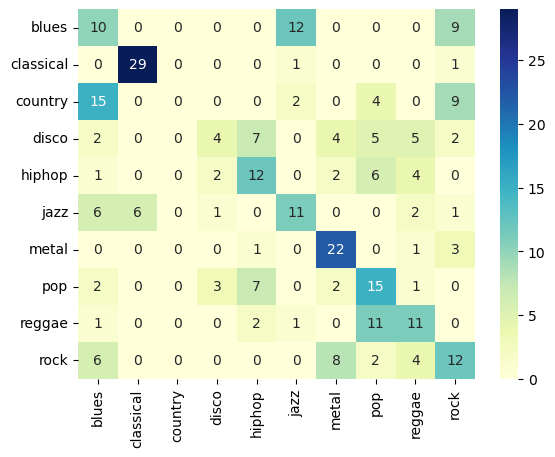

In [34]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

accuracylist=[]

accuracy = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, xticklabels=GTZAN_GENRES, yticklabels=GTZAN_GENRES, cmap='YlGnBu')
print('Accuracy: %.4f' % accuracy)
accuracylist.append(accuracy)

In [ ]:
# from random import shuffle
# shuffle(y_true)
# accuracy = accuracy_score(y_true, y_pred)
# cm = confusion_matrix(y_true, y_pred)
# sns.heatmap(cm, annot=True, xticklabels=GTZAN_GENRES, yticklabels=GTZAN_GENRES, cmap='YlGnBu')
# print('Randomness: %.4f' % accuracy)